In [3]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import cm
from sklearn import preprocessing
from sklearn.cluster import KMeans, dbscan
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from collections import Counter
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Load DataFrame with geographic coordinates

In [4]:
df_coords = pd.read_csv('./Csv/accidentes_coords.csv', sep=';')
df_coords.head(3)

fecha  hora_reporte  via  abscisa  tipo_atencion  \
0  13/08/2012            18    6        0              3   
1  28/08/2012            13    6        0              3   
2  28/09/2012            15    6        0              3   

   condiciones_climaticas  dia_semana  num_mes      x_coord      y_coord  \
0                       2           0        8  836317.1613  1189755.762   
1                       2           1        8  836317.1613  1189755.762   
2                       2           4        9  836317.1613  1189755.762   

   dia_festivo  
0            0  
1            0  
2            0

### Spatial distribution of the accidents

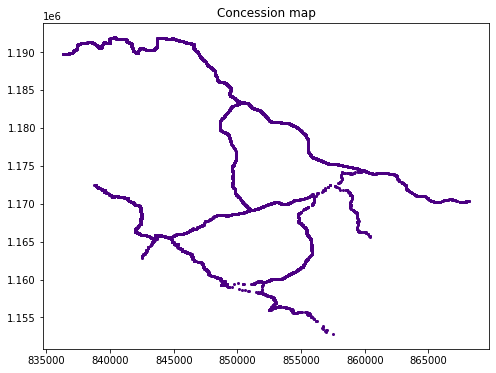

In [5]:
x = df_coords['x_coord']
y = df_coords['y_coord']

plt.figure(figsize=(8,6))
plt.plot(x, y, 'o', markersize=2, color='indigo');
plt.title('Concession map');

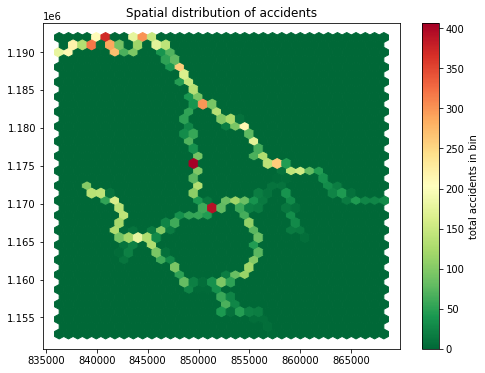

In [6]:
plt.figure(figsize=(8,6))
plt.hexbin(x, y, gridsize = 35, cmap='RdYlGn_r')
cb = plt.colorbar(label='total accidents in bin')
plt.title('Spatial distribution of accidents');

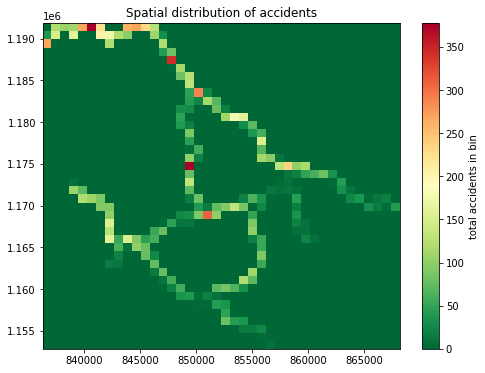

In [7]:
plt.figure(figsize=(8,6))
plt.hist2d(x, y, bins=40, cmap='RdYlGn_r')
cb = plt.colorbar(label='total accidents in bin')
plt.title('Spatial distribution of accidents');

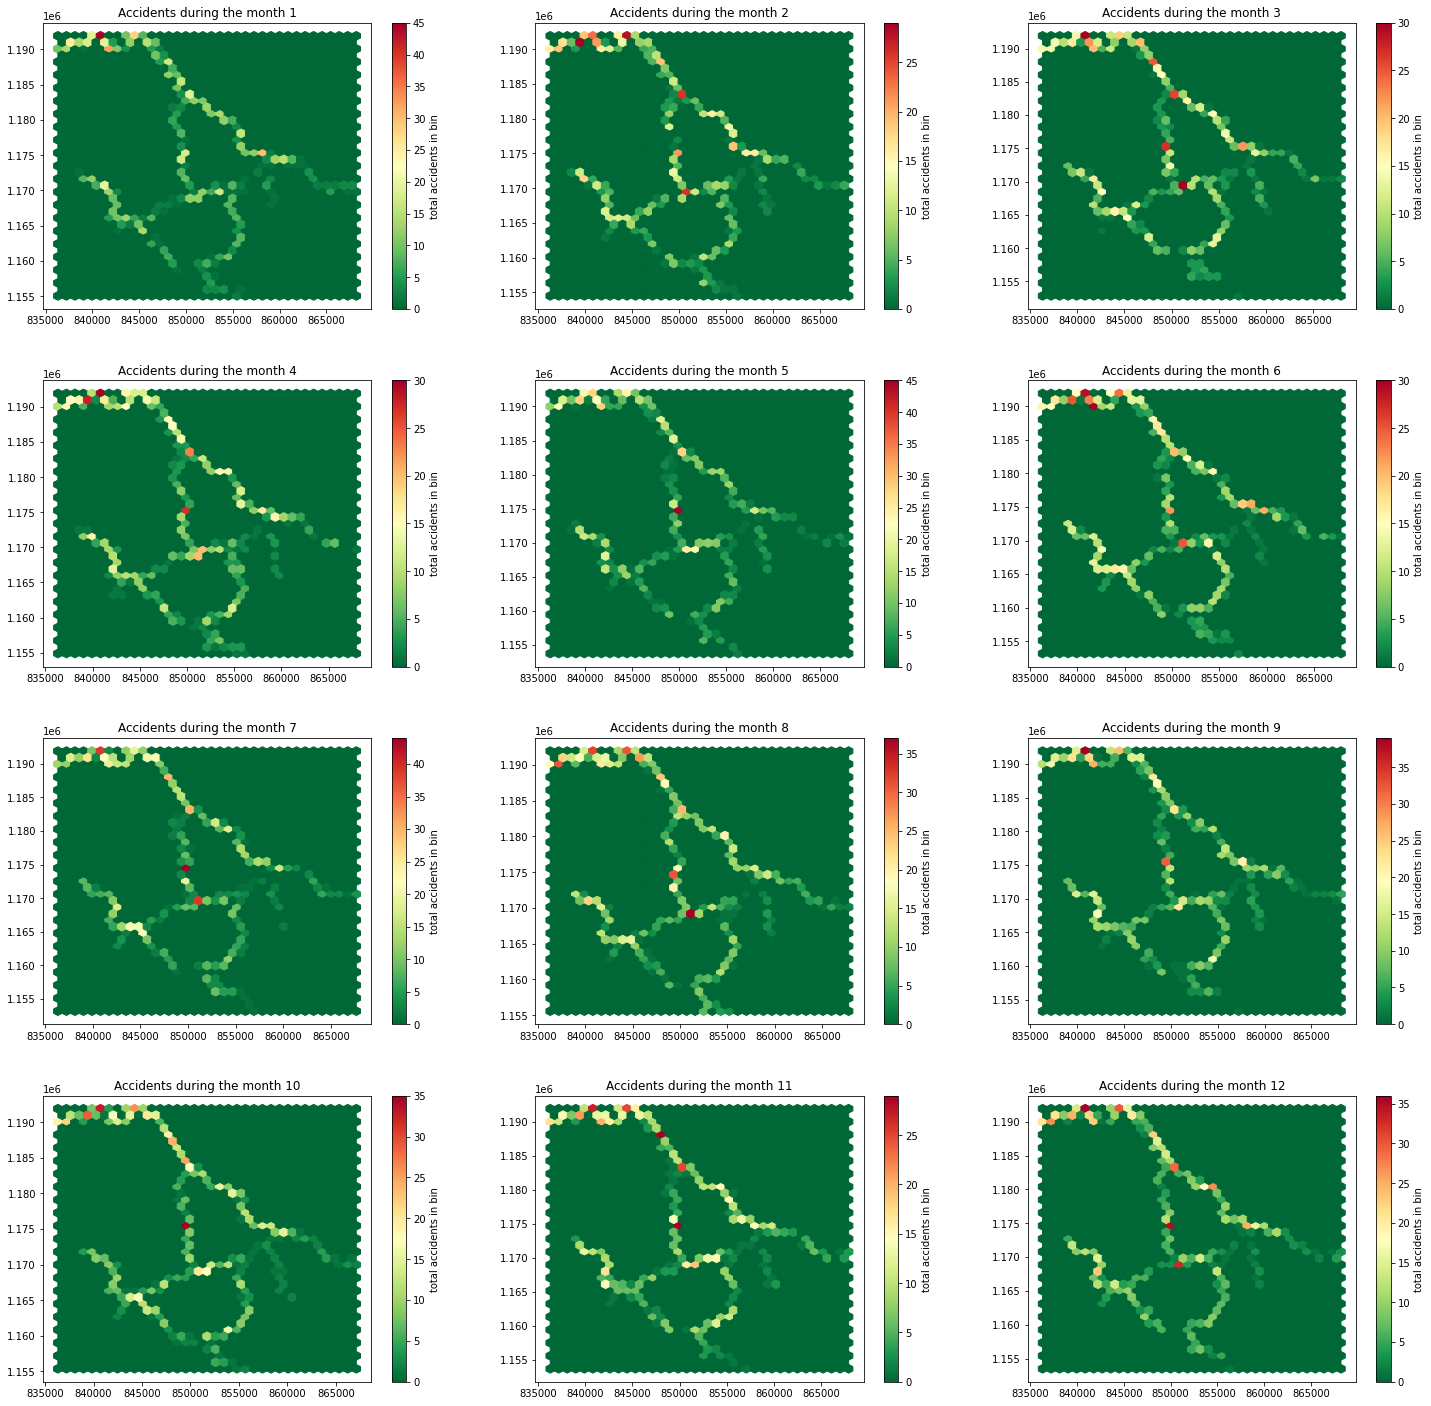

In [8]:
fig = plt.figure(figsize=(25, 25))  
fig.subplots_adjust(hspace=0.25, wspace=0.2)

for i in range(1, 13):
    ax = fig.add_subplot(4, 3, i)
    df_mes =  df_coords.loc[df_coords['num_mes'] == i]
    x_mes = df_mes['x_coord']
    y_mes = df_mes['y_coord']
    hb = ax.hexbin(x_mes, y_mes, gridsize = 35, cmap='RdYlGn_r')
    ax.set_title('Accidents during the month {}'.format(i))     
    cb = fig.colorbar(hb)
    cb.set_label(label='total accidents in bin')

### Unsupervised cluster analysis

In [9]:
X_df = df_coords[['x_coord', 'y_coord']]
labels = KMeans(8, random_state=0).fit_predict(X_df)
clusters = np.unique(labels)

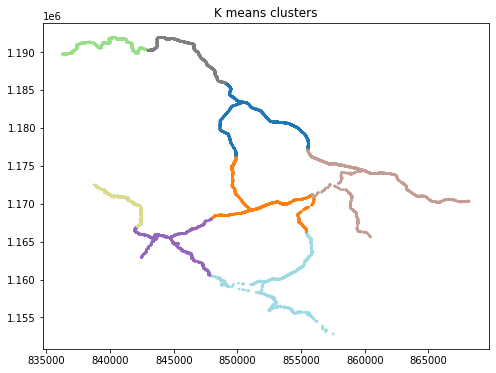

In [10]:
plt.figure(figsize=(8,6))
#plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(X_df['x_coord'], X_df['y_coord'], c=labels, cmap='tab20', s=3)
plt.title('K means clusters');

In [11]:
df_coords['cluster_id'] = pd.Series(labels)
df_coords.head(3)

fecha  hora_reporte  via  abscisa  tipo_atencion  \
0  13/08/2012            18    6        0              3   
1  28/08/2012            13    6        0              3   
2  28/09/2012            15    6        0              3   

   condiciones_climaticas  dia_semana  num_mes      x_coord      y_coord  \
0                       2           0        8  836317.1613  1189755.762   
1                       2           1        8  836317.1613  1189755.762   
2                       2           4        9  836317.1613  1189755.762   

   dia_festivo  cluster_id  
0            0           2  
1            0           2  
2            0           2

## Road clustering based on geometry

In [12]:
df_clusters = pd.read_csv('./Csv/accidentes_clusters.csv', sep=';')
df_clusters.head(3)

fecha  hora_reporte  via  abscisa  tipo_atencion  \
0  13/08/2012            18    6        0              3   
1  28/08/2012            13    6        0              3   
2  28/09/2012            15    6        0              3   

   condiciones_climaticas  dia_semana  num_mes      x_coord      y_coord  \
0                       2           0        8  836317.1613  1189755.762   
1                       2           1        8  836317.1613  1189755.762   
2                       2           4        9  836317.1613  1189755.762   

   cluster_id  dia_festivo  
0           0            0  
1           0            0  
2           0            0

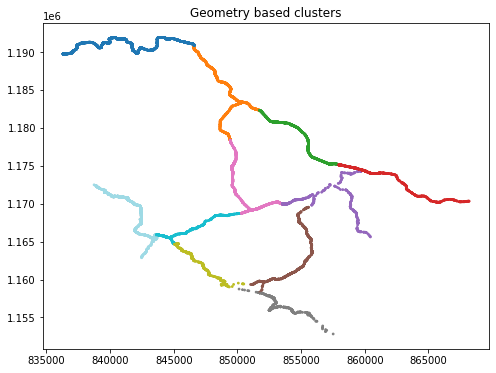

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(df_clusters['x_coord'], df_clusters['y_coord'], c=df_clusters['cluster_id'], cmap='tab20', s=3)
plt.title('Geometry based clusters');

### Sort dataframe by date

In [14]:
df_coords['fecha'] = pd.to_datetime(df_coords['fecha'], dayfirst=True)
df_clusters['fecha'] = pd.to_datetime(df_clusters['fecha'], dayfirst=True)

df_coords.sort_values(by=['fecha'], inplace=True)
df_clusters.sort_values(by=['fecha'], inplace=True)

df_clusters.head()

fecha  hora_reporte  via  abscisa  tipo_atencion  \
3602  2011-06-22            14    5     2800              3   
1560  2011-07-19            14    3    12800              3   
1561  2011-07-25            20    3    12800              3   
3603  2011-10-12             2    5     2800              1   
10040 2011-10-12             2    1     9500              3   

       condiciones_climaticas  dia_semana  num_mes      x_coord      y_coord  \
3602                        2           2        6  842754.7835  1163500.370   
1560                        2           1        7  840349.9943  1171010.656   
1561                        2           0        7  840349.9943  1171010.656   
3603                        2           2       10  842754.7835  1163500.370   
10040                       2           2       10  852326.4288  1169867.621   

       cluster_id  dia_festivo  
3602           10            0  
1560           10            0  
1561           10            0  
3603           10            0  
10040           6            0

### Features selection

In [15]:
X_coords = df_coords.drop([
           'fecha', 
           'via', 
           #'cluster_id',
           'abscisa', 
           'tipo_atencion', 
           'x_coord',
           'y_coord'], axis = 1)

X_clusters = df_clusters.drop([
             'fecha', 
             'via', 
             #'cluster_id',
             'abscisa', 
             'tipo_atencion', 
             'x_coord',
             'y_coord'], axis = 1)

X_coords.head()

hora_reporte  condiciones_climaticas  dia_semana  num_mes  dia_festivo  \
3602             14                       2           2        6            0   
1560             14                       2           1        7            0   
1561             20                       2           0        7            0   
3603              2                       2           2       10            0   
10040             2                       2           2       10            0   

       cluster_id  
3602            3  
1560            6  
1561            6  
3603            3  
10040           1

### Get dummy variables

In [16]:
def convert_columns_to_dummy(df, columns):
    df_dummy = df
    
    # For df_clusters DataFrame
    for column in columns:
        if column not in df_dummy: 
            continue
        
        dummy_columns = pd.get_dummies(df_dummy[column], prefix = column)
        df_dummy = df_dummy.join(dummy_columns)

        # Drop original column
        df_dummy = df_dummy.drop(column, axis = 1)
    return df_dummy

In [17]:
dummy_columns = [
    'hora_reporte',
    'condiciones_climaticas',
    'dia_semana',
    'num_mes',
    'cluster_id',
    ]

X1 = convert_columns_to_dummy(X_coords, dummy_columns)
X2 = convert_columns_to_dummy(X_clusters, dummy_columns)

X1.head(3)

dia_festivo  hora_reporte_0  hora_reporte_1  hora_reporte_2  \
3602            0               0               0               0   
1560            0               0               0               0   
1561            0               0               0               0   

      hora_reporte_3  hora_reporte_4  hora_reporte_5  hora_reporte_6  \
3602               0               0               0               0   
1560               0               0               0               0   
1561               0               0               0               0   

      hora_reporte_7  hora_reporte_8  ...  num_mes_11  num_mes_12  \
3602               0               0  ...           0           0   
1560               0               0  ...           0           0   
1561               0               0  ...           0           0   

      cluster_id_0  cluster_id_1  cluster_id_2  cluster_id_3  cluster_id_4  \
3602             0             0             0             1             0   
1560             0             0             0             0             0   
1561             0             0             0             0             0   

      cluster_id_5  cluster_id_6  cluster_id_7  
3602             0             0             0  
1560             0             1             0  
1561             0             1             0  

[3 rows x 56 columns]

### Choose the dataframe to use

In [18]:
# X1 -> K-means clustering 
# X2 -> Geometry clustering
X = X1

### Train test data split

In [19]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)

### One Class SVM

In [20]:
clf_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale').fit(X_train)

y_pred_train = clf_svm.predict(X_train)
y_pred_test = clf_svm.predict(X_test)

values_count_train = Counter(y_pred_train)
values_count_test = Counter(y_pred_test)

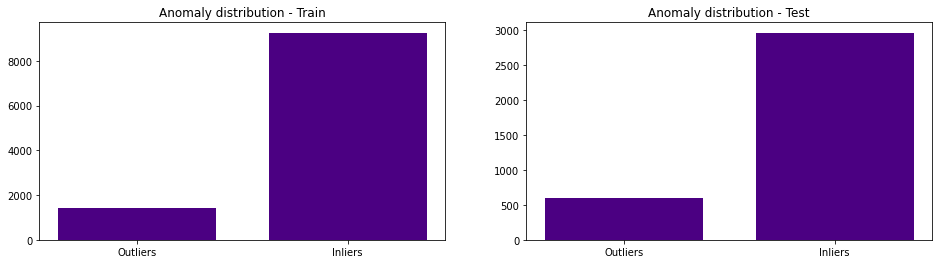

In [21]:
plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.bar(values_count_train.keys(), values_count_train.values(), width=1.5, align='center', color='indigo');
plt.xticks([-1, 1], ['Outliers','Inliers']);
plt.title('Anomaly distribution - Train');

plt.subplot(1,2,2)
plt.bar(values_count_test.keys(), values_count_test.values(), width=1.5, align='center', color='indigo')
plt.xticks([-1, 1], ['Outliers','Inliers']);
plt.title('Anomaly distribution - Test');

### Isolation Forest

In [22]:
clf_If = IsolationForest(random_state=42, contamination=0.1)
clf_If.fit(X_train)

y_pred_train = clf_If.predict(X_train)
y_pred_test = clf_If.predict(X_test)

values_count_train = Counter(y_pred_train)
values_count_test = Counter(y_pred_test)

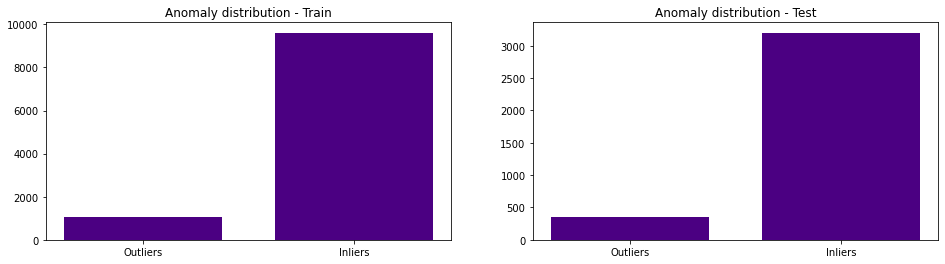

In [23]:
plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.bar(values_count_train.keys(), values_count_train.values(), width=1.5, align='center', color='indigo');
plt.xticks([-1, 1], ['Outliers','Inliers']);
plt.title('Anomaly distribution - Train');

plt.subplot(1,2,2)
plt.bar(values_count_test.keys(), values_count_test.values(), width=1.5, align='center', color='indigo')
plt.xticks([-1, 1], ['Outliers','Inliers']);
plt.title('Anomaly distribution - Test');

### Test the models

In [24]:
def test_model(clf, X_test, num_of_sectors, descriptor_to_vary):
    numer_of_experiments = 0
    successful_experiments = 0
    samples_number = X_test.shape[0]
    
    # For categorical "descriptor_to_vary"
    # unique_descriptors = np.unique(X_test[descriptor_to_vary])
     
    for index in tqdm(range(samples_number)):
        row = X_test.iloc[index].copy()  
        original_descriptors = row[descriptor_to_vary]

        # For categorical "descriptor_to_vary"
        # dummy_descriptors = [descriptor for descriptor in unique_descriptors if descriptor != original_descriptor]
        
        # For one hot encoding "descriptor_to_vary"
        dummy_descriptors = [descriptor for descriptor in range(len(original_descriptors)) if original_descriptors[descriptor] != 1]

        test_subset = pd.DataFrame()
        test_subset = test_subset.append(row, ignore_index=True)

       # Generate dummy data for the other clusters
        for dummy_descriptor in dummy_descriptors:        

            # For one hot encoding "descriptor_to_vary"
            one_hot_column = np.zeros(len(original_descriptors))
            one_hot_column[dummy_descriptor] = 1
            row[descriptor_to_vary] = one_hot_column    
            
            # For categorical "descriptor_to_vary"
            # row[descriptor_to_vary] = dummy_descriptor
            
            test_subset = test_subset.append(row, ignore_index=True)

        # Get score for each cluster (bigger is better)
        score = clf.score_samples(test_subset)

        # Get the indices of the best-scoring predictions
        best_scores_indexes = np.argsort(score)[::-1][0 : num_of_sectors]

        # 0 is the index of the true sample
        if 0 in best_scores_indexes: successful_experiments += 1 
        numer_of_experiments = numer_of_experiments + 1

    success_rate = successful_experiments * 100 / numer_of_experiments   
    return success_rate

### Set test settings - assuming 2 sectors

In [25]:
num_of_sectors = 2

# For categorical "descriptor_to_vary"
# descriptor_to_vary = 'cluster_id'

# For one hot encoding "descriptor_to_vary
number_of_clusters = len(X.columns[X.columns.str.startswith('cluster_id_')])

descriptor_to_vary = ['cluster_id_' + str(x) for x in range(number_of_clusters)]

### Test one class svm model

In [26]:
success_rate =  test_model(clf_svm, X_test, num_of_sectors, descriptor_to_vary)

print('-'*50)
print('The model covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

100%|██████████| 3560/3560 [01:30<00:00, 39.24it/s]

--------------------------------------------------
The model covers 28.57% of accidents 
with 2 sectors 
--------------------------------------------------


### Test Isolation forest model

In [27]:
success_rate =  test_model(clf_If, X_test, num_of_sectors, descriptor_to_vary)

print('-'*50)
print('The model covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

100%|██████████| 3560/3560 [03:55<00:00, 15.10it/s]

--------------------------------------------------
The model covers 28.96% of accidents 
with 2 sectors 
--------------------------------------------------


### Assuming 3 sectors

In [28]:
num_of_sectors = 3

In [29]:
success_rate =  test_model(clf_svm, X_test, num_of_sectors, descriptor_to_vary)

print('-'*50)
print('The model covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

100%|██████████| 3560/3560 [01:27<00:00, 40.73it/s]

--------------------------------------------------
The model covers 41.52% of accidents 
with 3 sectors 
--------------------------------------------------


In [30]:
success_rate =  test_model(clf_If, X_test, num_of_sectors, descriptor_to_vary)

print('-'*50)
print('The model covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

100%|██████████| 3560/3560 [03:51<00:00, 15.36it/s]

--------------------------------------------------
The model covers 41.91% of accidents 
with 3 sectors 
--------------------------------------------------


### Assuming 4 sectors

In [31]:
num_of_sectors = 4

In [32]:
success_rate =  test_model(clf_svm, X_test, num_of_sectors, descriptor_to_vary)

print('-'*50)
print('The model covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

100%|██████████| 3560/3560 [01:30<00:00, 39.31it/s]

--------------------------------------------------
The model covers 52.81% of accidents 
with 4 sectors 
--------------------------------------------------


In [33]:
success_rate =  test_model(clf_If, X_test, num_of_sectors, descriptor_to_vary)

print('-'*50)
print('The model covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

100%|██████████| 3560/3560 [03:41<00:00, 16.05it/s]

--------------------------------------------------
The model covers 53.68% of accidents 
with 4 sectors 
--------------------------------------------------


## Random selection of clusters

In [34]:
def monte_carlo():    
    
    #random_clusters = []

    #for i in range(10000):
        #rnd_cluster = np.random.choice(range(number_of_clusters+1))
        #random_clusters.append(rnd_cluster)
    
    #return max(random_clusters, key=random_clusters.count)    
    return np.random.choice(range(number_of_clusters+1))

def calculate_random(num_of_sectors, df):
    
    df_montecarlo = pd.DataFrame()

    df_montecarlo['cluster_id'] = df['cluster_id']
    df_montecarlo['result'] = 0

    for i in range(num_of_sectors):    
        df_montecarlo['mc_cluster_{}'.format(i)] = [monte_carlo() for i in range(df_coords.shape[0])]
        df_montecarlo['result'] = df_montecarlo['cluster_id'].eq(df_montecarlo['mc_cluster_{}'.format(i)]) | \
                                  df_montecarlo['result']

    num_of_coincidences = Counter(df_montecarlo['result'])[1]
    coincidences_percent = (num_of_coincidences/len(df_montecarlo['cluster_id']))*100
    
    return coincidences_percent

### Random test assuming 2 sectors

In [35]:
success_rate = calculate_random(num_of_sectors=2, df=df_coords)

print('-'*50)
print('Random selecion covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

--------------------------------------------------
Random selecion covers 21.50% of accidents 
with 4 sectors 
--------------------------------------------------


### Random test assuming 3 sectors

In [36]:
success_rate = calculate_random(num_of_sectors=3, df=df_coords)

print('-'*50)
print('Random selecion covers {0:.2f}% of accidents \nwith {1} sectors '.format(success_rate, num_of_sectors))
print('-'*50)

--------------------------------------------------
Random selecion covers 29.83% of accidents 
with 4 sectors 
--------------------------------------------------
